[*********************100%***********************]  3 of 3 completed
C:\Users\abhij\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


1 Day VaR at 95% CI is Rs.18574
CVaR or Expected Shortfall beyond 95% CI is Rs.22741


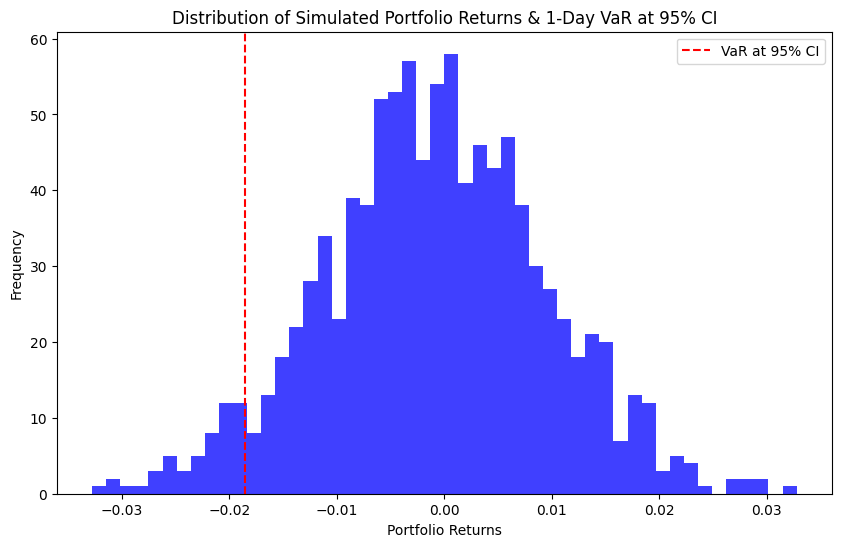

In [ ]:
import pandas as pd 
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
from scipy.stats import norm


class VaR:

    def __init__(self,tickers,weights,start_date,end_date,portfolio_value):
        self.tickers = tickers
        self.weights = weights
        self.start_date = start_date
        self.end_date = end_date 
        self.portfolio_value = portfolio_value

        self.mu = None
        self.volatility = None 
        self.corr = None
        self.cholesky = None
        self.data = None 
        self.returns = None
        self.uncorrelated_rvs = None
        self.correlated_rvs = None
        self.portfolio_returns = None 
        self.VaR = None

    def fetch_data(self):
        """ 
        Fetch closing price for the given tickers from Yahoo Finance
        """

        if self.tickers is None:
            raise ValueError("Pass valid stock names")

        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)['Close']
        self.data = self.data.dropna()
        return self.data
    
    def calculate_returns_and_statistics(self):

        if self.data is None:
            raise ValueError("Fetch stock price data")

        """
        Calculate the stock price log returns
        """
        self.returns = (np.log(self.data/self.data.shift(1))).dropna()

        """
        Calculate returns statistics
        """

        self.mu = self.returns.mean().values
        self.volatility = np.std(self.returns).values
        self.corr = np.corrcoef(self.returns.T) 

        # return self.corr


    def simulate_correlated_rvs(self,n_sim = 1000):

        if self.returns is None:
            raise ValueError(" Generate the stock price returns")
        
        """ 
        Simulated correlated random variables using Cholesky Decomposition 

        Step 1 : Compute correlation matrix R
        Step 2 : Compute L = Cholesky(R)
        Step 3 : Generate uncorrelated Z~N(0,1)
        Step 4 : Correlated normals: X = LZ

        """
        
        """ 
        Simulate 1000 uncorrelated random variables from a Standard Normal Distribution
        """
        n_stocks = len(self.returns.columns)

        self.uncorrelated_rvs = np.random.normal(0,1, size=(n_sim, n_stocks))
        
        
        """
        Compute Cholesky decomposition for correlation using the correlation matrix
        """
        self.cholesky = np.linalg.cholesky(self.corr)

        """ 
        Correlated normal random variables
        """

        self.correlated_rvs = np.dot(self.uncorrelated_rvs, self.cholesky)

        # return self.correlated_rvs

    def simulate_stock_price(self):

        if self.correlated_rvs is None:
            raise ValueError("Generate correlated normal random variables using Cholesky decomposition")
        
        """ 
        To simulate stock prices using Monte Carlo, we usually assume the Geometric Brownian Motion (GBM) model:

        S(t) = S(0).exp((μ - σ²/2)t +  σ*W(t))

        Where 
        S(t) = stock price at time t
        S(0) = latest stock price 
        μ = expected return (drift)
        σ = volatility
        W(t) = standard Brownian motion
        t = time period (in years)

        """
        
        if self.mu is None or self.volatility is None:
            raise ValueError("Calculate returns and statistics before simulating stock prices")
        
        n_stocks = len(self.returns.columns)
        n_sim = self.correlated_rvs.shape[0]
        latest_prices = self.data.iloc[-1].values
        time_period = 1
        simulated_prices = np.zeros((n_sim, n_stocks))
        for i in range(n_stocks):
            simulated_prices[:, i] = latest_prices[i] * np.exp(
                (self.mu[i] - 0.5 * self.volatility[i] ** 2) * time_period +
                self.volatility[i] * self.correlated_rvs[:, i] * np.sqrt(time_period)
            )
        return pd.DataFrame(simulated_prices)
    
    def simulate_portfolio_returns(self):
        if self.correlated_rvs is None:
            raise ValueError("Generate correlated normal random variables using Cholesky decomposition")
        
        """
        Simulate portfolio returns using the weights and correlated random variables
        """
        if self.mu is None or self.volatility is None:
            raise ValueError("Calculate returns and statistics before simulating portfolio returns")
        
        n_sim = self.correlated_rvs.shape[0]
        self.portfolio_returns = np.zeros(n_sim)
        
        for i in range(n_sim):
            self.portfolio_returns[i] = np.dot(self.weights, self.mu + self.correlated_rvs[i] * self.volatility)
        
        # return pd.DataFrame(self.portfolio_returns)
    
    def calculate_VaR(self, confidence_interval=0.95):
        """
        Calculate Value at Risk (VaR) using the simulated portfolio returns
        """
        if self.portfolio_returns is None:
            raise ValueError("Simulate portfolio returns before calculating VaR")
        
        # Calculate the VaR at the specified confidence interval
        var_threshold = np.percentile(self.portfolio_returns, (1 - confidence_interval) * 100)
        self.VaR = -var_threshold * self.portfolio_value
        
        return self.VaR
    
    def expected_shortfall(self, confidence_interval=0.95):
        """
        Calculate Expected Shortfall (ES) at the specified confidence interval
        """
        if self.portfolio_returns is None:
            raise ValueError("Simulate portfolio returns before calculating Expected Shortfall")
        
        var_threshold = np.percentile(self.portfolio_returns, (1 - confidence_interval) * 100)
        es = -self.portfolio_returns[self.portfolio_returns <= var_threshold].mean() * self.portfolio_value
        
        return es

    def plot_portfolio_returns(self):
        if self.portfolio_returns is None:
            raise ValueError("Simulate portfolio returns before plotting")
        
        plt.figure(figsize=(10, 6))
        plt.hist(self.portfolio_returns, bins=50, alpha=0.75, color='blue')
        plt.title('Distribution of Simulated Portfolio Returns & 1-Day VaR at 95% CI')
        plt.xlabel('Portfolio Returns')
        plt.ylabel('Frequency')
        plt.axvline(x=np.percentile(self.portfolio_returns, 5), color='red', linestyle='--', label='VaR at 95% CI')
        plt.legend()
        plt.show()




tickers = ['TCS.NS', 'INFY.NS', 'RELIANCE.NS']
weights = [0.3,0.3,0.4]
start_date = '2024-08-01'
end_date = '2025-08-01'
portfolio_value = 1000000
confidence_interval=0.95

model = VaR(tickers,weights,start_date,end_date,portfolio_value)
model.fetch_data()
model.calculate_returns_and_statistics()
model.simulate_correlated_rvs()
model.simulate_stock_price()
model.simulate_portfolio_returns()


print(f'1 Day VaR at 95% CI is Rs.{round(model.calculate_VaR())}')
print(f'CVaR or Expected Shortfall beyond 95% CI is Rs.{round(model.expected_shortfall())}')
# Plot the distribution of simulated portfolio returns
model.plot_portfolio_returns()

